In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print('list of input files:\n* ',f)

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
data['c'] = np.copy(temp)[:,-1]

print('\ninput data has shape:\tx ',  data['x'].shape)
print('target data has shape:\tc ', data['c'].shape)
print()

list of input files:
*  ['full_speach_data.ssv']

input data has shape:	x  (990, 10)
target data has shape:	c  (990,)



In [4]:
# normalize data in the range [0,1]
data['nx'] = np.nan*np.empty(data['x'].shape)

for jj in range(data['x'].shape[1]):
    data['nx'][:,jj] = (data['x'][:,jj]-np.amin(data['x'][:,jj]))/(np.amax(data['x'][:,jj])-np.amin(data['x'][:,jj]))

if 0:
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    ax1.plot(data['nx'])

    plt.show()
    plt.close()

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'

setting = 0
if setting == 0:
    train['x'] = np.copy(data['nx'][:default[0],:])
    train['c'] = np.copy(data['c'][:default[0]])
    
    test['x']  = np.copy(data['nx'][-default[1]:,:])
    test['c']  = np.copy(data['c'][-default[1]:])
#elif setting == 1:

print('\ntrain set')    
print(train['x'].shape)
print(train['c'].shape)

print('\ntest set')
print(test['x'].shape)
print(test['c'].shape)


train set
(528, 10)
(528,)

test set
(462, 10)
(462,)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
c = Variable( torch.from_numpy(train['c']).long() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
c_test = Variable( torch.from_numpy(test['c']).long() )

In [7]:
### import UTILITY functions
from modules.graph_utils import *
    #
    # def show_graph(obj, string='loglog'):
    # def print_spec(obj):

### import NETWORK LOOPS functions
from modules.network_loops import *
    #
    # def run_training(obj, train_x, train_y, valid_x, valid_y):
    # def run_test(obj, test_x, test_y, verbose=True):

from modules.models import *
    #
    # class Baseline(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BaseSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BestFitSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    #
    # def generate_entry(obj, verbose = False):

# prints errors in semi-log axis
show_type = 'lin'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
### dimensions of 
# N is batch size
N     = train['x'].shape[0]
# D_in is input dimension
D_in  = train['x'].shape[1]
# H*n is the hidden layer dimension
H     = 11
n     = 8
# is the last hidden layer size
D_out = 11

# numer of epochs
epochs = int(4e3)

In [9]:
##### model settings
k = 1e-2
base_lr = k*5e0
sigm_lr = k*12
best_lr = k*.65e-1
fitr_lr = k*1

base_mom = 0.25
sigm_mom = 0.25
best_mom = 0.5
fitr_mom = 0.0

In [10]:
# settings: '' name, H = width of hidden layers, n = number of hidden H-layers,
#           NL_out = nonlinear output layer/sum-only output layer,
#           'model'
#           'criterion' and parameters
#           'optimizer' and parameters

LL = []
#for size in [[11,2], [11,3], [22,2], [22,3]]:
#    for NL_type in [ ['base', base_lr, base_mom, False],
#                      ['sigmoid', sigm_lr, sigm_mom, True],
#                      ['bestfit', best_lr, best_mom, True]
#                    ]:
#        LL.append(
#            [['%s %dx%d'%(NL_type[0], size[0], size[1]), N, D_in, size[0], size[1], D_out, NL_type[3], epochs],
#             NL_type[0],
#             'CEL', [True],
#             'SGD', [NL_type[1], NL_type[2]],
#             'StepLR', [100, 0.99]
#            ]
#        )
size = [11,2]
NL_type = ['fitrelu', fitr_lr, fitr_mom, True]
rep = 5
par_size = 1
#for lrr in np.logspace(-3,-2,par_size):
#    for jj in range(rep):
#        LL.append(
#            [['%d lrr %.1e'%(jj,lrr), N, D_in, size[0], size[1], D_out, NL_type[3], epochs],
#             NL_type[0],
#             'CEL', [True],
#             #'SGD', [NL_type[1], NL_type[2]],
#             'SGD', [lrr, NL_type[2]],
#             'StepLR', [100, 0.99]
#            ]
#        )
#for mom in [0]:
#    for jj in range(rep):
#        LL.append(
#            [['%d mom %.1e'%(jj,mom), N, D_in, size[0], size[1], D_out, NL_type[3], epochs],
#             NL_type[0],
#             'CEL', [True],
#             #'SGD', [NL_type[1], NL_type[2]],
#             'SGD', [NL_type[1], mom],
#             'StepLR', [100, 0.99]
#            ]
#        )
for gamma in [0.99]:#[0.6,0.80,0.9,0.99]:
    for jj in range(rep):
        LL.append(
            [['%d gamma %.2f'%(jj,gamma), N, D_in, size[0], size[1], D_out, NL_type[3], epochs],
             NL_type[0],
             'CEL', [True],
             'SGD', [NL_type[1], NL_type[2]],
             'StepLR', [100, gamma]
            ]
        )

print(len(LL))

models = {}
results = []

verb=False

5


In [11]:
for ii in range(len(LL)):
    models[ii] = generate_entry(LL[ii], verbose=verb)
    run_training(models[ii], x, c, x_test, c_test)
    results.append( max(models[ii][-3][:]) )
    print('%s\t%.2f%%'%(models[ii][0][0],results[ii]) )


# # # # # # # # # # # # # #

epochs	error		validation
200 	2.43613 	2.43738 	9.09
400 	2.39901 	2.40818 	7.58
600 	2.38350 	2.39246 	13.85
800 	2.37213 	2.38307 	13.42
1000 	2.37141 	2.37881 	14.94
1200 	2.32377 	2.34462 	19.48
1400 	2.30373 	2.32364 	17.32
1600 	2.28785 	2.31167 	19.70
1800 	2.27179 	2.29031 	24.46
2000 	2.26442 	2.28599 	19.70
2200 	2.25561 	2.29345 	15.58
2400 	2.46398 	2.46191 	9.09
2600 	2.41208 	2.42908 	9.74
2800 	2.27726 	2.30787 	18.18
3000 	2.26374 	2.28362 	19.05
3200 	2.23334 	2.29618 	20.35
3400 	2.23158 	2.29644 	16.88
3600 	2.20238 	2.25887 	15.15
3800 	2.15070 	2.20909 	20.56
4000 	2.35364 	2.37037 	14.07
0 gamma 0.99	24.46%

# # # # # # # # # # # # # #

epochs	error		validation
200 	2.44074 	2.44053 	9.09
400 	2.39414 	2.39783 	9.09
600 	2.38634 	2.38925 	16.88
800 	2.38016 	2.38527 	17.75
1000 	2.37551 	2.38096 	17.97
1200 	2.36738 	2.37463 	17.97
1400 	2.35501 	2.37113 	17.75
1600 	2.36679 	2.37917 	22.08
1800 	2.50168 	2.50015 	9.09
2000 	2.35118 	

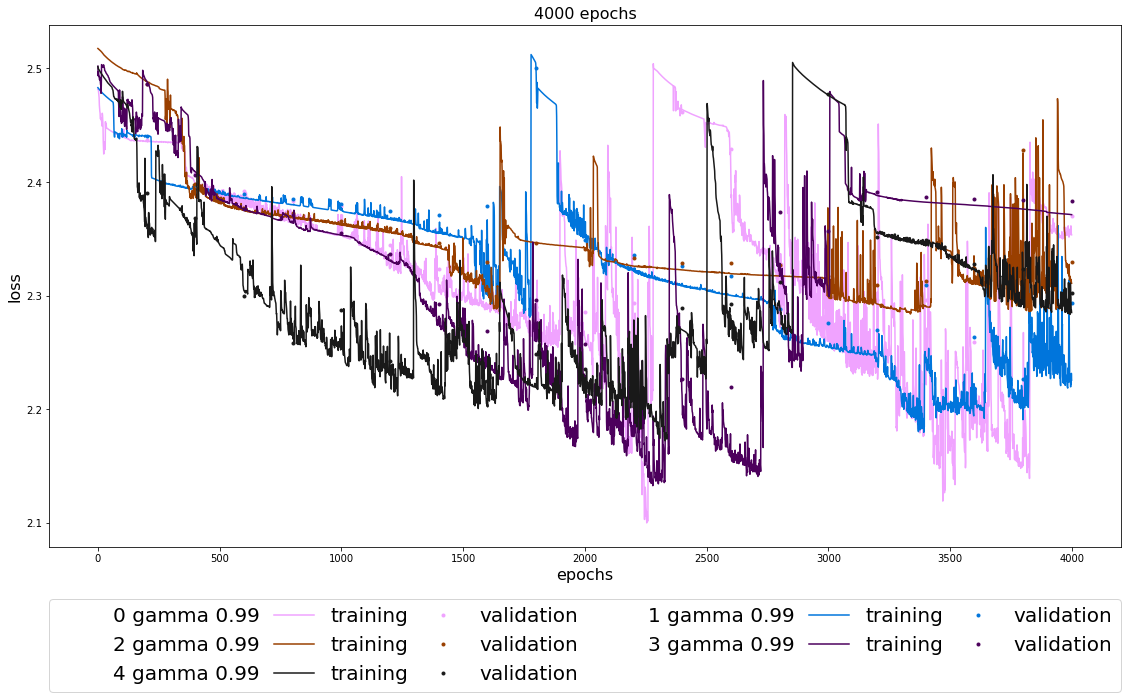

In [12]:
show_graph(models, show_type)

In [13]:
for ii,mm in models.items():
    print('%s\t%3.2f %%'%(models[ii][0][0], results[ii]))

0 gamma 0.99	24.46 %
1 gamma 0.99	27.92 %
2 gamma 0.99	20.13 %
3 gamma 0.99	23.81 %
4 gamma 0.99	24.89 %


In [14]:
for jj in range(par_size):
    #print('{:.2e}: ({:.2f} ± {:.2f})%'.format(models[rep*jj][5][0],np.average(results[rep*jj:rep*(jj+1)]),np.std(results[rep*jj:rep*(jj+1)])))
    #print('{:.2f}: ({:.2f} ± {:.2f})%'.format(models[rep*jj][5][1],np.average(results[rep*jj:rep*(jj+1)]),np.std(results[rep*jj:rep*(jj+1)])))
    print('{:.2f}: ({:.2f} ± {:.2f})%'.format(models[rep*jj][7][1],np.average(results[rep*jj:rep*(jj+1)]),np.std(results[rep*jj:rep*(jj+1)])))

0.99: (24.24 ± 2.49)%


In [15]:
#show_graph(models, show_type)
#
#for ii,mm in models.items():
#    print('%s\t%3.2f %%'%(models[ii][0][0], results[ii]))
#
#print('({:.2f} ± {:.2f})%'.format(np.average(results[:]),np.std(results[:])))

In [16]:
# create empty dictionary {} and list []
#models2 = models.copy()
#results2 = []
#
#for jj in range(20): # number of repetitions
#    run_training(models2[jj], x, c, x_test, c_test)
#    #show_graph(models[jj], show_type)
#    results2.append(run_test(models2[jj], x, c))
#    print('%d\t%s\t%.2f%%'%(jj,models2[jj][0][0],results2[jj]) )

In [17]:
#show_graph(models2, show_type)

#for ii,mm in models2.items():
#    print('%s\t%3.2f %%'%(models2[ii][0][0], results2[ii]))

#print('({:.2f} ± {:.2f})%'.format(np.average(results2[:10]),np.std(results2[:10])))